## Import Library

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path='/content/drive/MyDrive/courses/indoai/face_recognition/Datasets/'

In [4]:
# Load data from a CSV file
data = pd.read_csv(os.path.join(data_path, 'gender_classification.csv'))

# Split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
data.columns = ["image_path", "Male"]

data

,image_path,Male
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0
...,...,...
9995,202548.jpg,0
9996,202554.jpg,1
9997,202557.jpg,0
9998,202566.jpg,1


## Preprocessing

In [6]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
         [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
         [0.229, 0.224, 0.225])
    ]),
}


In [8]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "images"), transform=data_transforms['train'])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)

test_set = GenderDataset(test_data, os.path.join(data_path, "images"), transform=data_transforms['test'])
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Architecture

In [9]:
# please Define the model optimizer and criterion (loss function)
model_ft = models.resnet34(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2) 
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Modeling

In [10]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!mkdir /content/drive/MyDrive/courses/indoai/face_recognition/model_save

mkdir: cannot create directory ‘/content/drive/MyDrive/courses/indoai/face_recognition/model_save’: File exists


In [12]:
import time
from torch.autograd import Variable
from sklearn.metrics import f1_score
from torcheval.metrics.functional import multiclass_f1_score 

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_score = 0.0

    # eval
    train_loss=[]
    train_acc=[]
    train_f1_score=[]
    
    test_loss=[]
    test_acc=[]
    test_f1_score=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        test_preds = torch.tensor([], dtype=torch.long).to("cuda")
        test_labels = torch.tensor([], dtype=torch.long).to("cuda")

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

                test_preds = torch.cat((test_preds, preds), dim=0)
                test_labels = torch.cat((test_labels, labels.data), dim=0)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            # Add these lines to obtain f1_score    
            f1_score = multiclass_f1_score(test_preds, test_labels, num_classes=2, average='micro')


            print('{} Loss: {:.4f} Acc: {:.4f} f1_score {:.4f}'.format(
                phase, epoch_loss, epoch_acc, f1_score))

            if phase == 'train':
                # save eval score
                train_loss+=[epoch_loss.item()]
                train_acc+=[epoch_acc.item()]
                train_f1_score+=[f1_score.item()]

            if phase == 'test':
                # save eval score
                test_loss+=[epoch_loss.item()]
                test_acc+=[epoch_acc.item()]
                test_f1_score+=[f1_score.item()]

            # deep copy the model
            if phase == 'test' and f1_score > best_score:
                best_score = f1_score
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'/content/drive/MyDrive/courses/indoai/face_recognition/model_save/point_resnet34_8020_best.pth')

        print()
    
    # save eval dict
    eval_dict = { 'train_loss':train_loss,
                  'train_acc':train_acc,
                  'train_f1_score':train_f1_score,
                  'test_loss':test_loss,
                  'test_acc':test_acc,
                  'test_f1_score':test_f1_score,
                  }

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Score: {:4f}'.format(best_score))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, eval_dict

In [13]:
dataloders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [14]:
use_gpu = torch.cuda.is_available()

if use_gpu:
  model = model_ft.to("cuda")

In [15]:
model, eval_dict = train_model(model, dataloders, dataset_sizes, criterion, optimizer, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0042 Acc: 0.8834 f1_score 0.8834
test Loss: 0.0014 Acc: 0.9665 f1_score 0.9000

Epoch 1/9
----------
train Loss: 0.0029 Acc: 0.9193 f1_score 0.9193
test Loss: 0.0015 Acc: 0.9615 f1_score 0.9277

Epoch 2/9
----------
train Loss: 0.0023 Acc: 0.9373 f1_score 0.9373
test Loss: 0.0012 Acc: 0.9710 f1_score 0.9440

Epoch 3/9
----------
train Loss: 0.0021 Acc: 0.9458 f1_score 0.9457
test Loss: 0.0012 Acc: 0.9730 f1_score 0.9512

Epoch 4/9
----------
train Loss: 0.0019 Acc: 0.9508 f1_score 0.9507
test Loss: 0.0014 Acc: 0.9720 f1_score 0.9550

Epoch 5/9
----------
train Loss: 0.0018 Acc: 0.9518 f1_score 0.9517
test Loss: 0.0013 Acc: 0.9725 f1_score 0.9559

Epoch 6/9
----------
train Loss: 0.0018 Acc: 0.9505 f1_score 0.9505
test Loss: 0.0011 Acc: 0.9735 f1_score 0.9551

Epoch 7/9
----------
train Loss: 0.0015 Acc: 0.9604 f1_score 0.9604
test Loss: 0.0011 Acc: 0.9780 f1_score 0.9639

Epoch 8/9
----------
train Loss: 0.0016 Acc: 0.9596 f1_score 0.9596
test Loss: 0

## Evaluation

In [16]:
eval_dict

{'train_loss': [0.00423347856849432,
  0.0028575111646205187,
  0.0023135365918278694,
  0.0021242734510451555,
  0.0019071382703259587,
  0.0017582406289875507,
  0.0017882990650832653,
  0.0015322950202971697,
  0.0016471641138195992,
  0.0015339499805122614],
 'train_acc': [0.8833750486373901,
  0.9192500710487366,
  0.937250018119812,
  0.9457500576972961,
  0.9507500529289246,
  0.9517500400543213,
  0.9505000710487366,
  0.9603750705718994,
  0.9596250653266907,
  0.9607500433921814],
 'train_f1_score': [0.8833750486373901,
  0.9192500114440918,
  0.937250018119812,
  0.9457499980926514,
  0.9507499933242798,
  0.9517499804496765,
  0.9505000114440918,
  0.9603750109672546,
  0.9596250057220459,
  0.9607499837875366],
 'test_loss': [0.001438529696315527,
  0.0014661162858828902,
  0.0012232429580762982,
  0.001195993390865624,
  0.0013603265397250652,
  0.001288732048124075,
  0.0011155839310958982,
  0.001140669803135097,
  0.0011278793681412935,
  0.0010556874331086874],
 'test

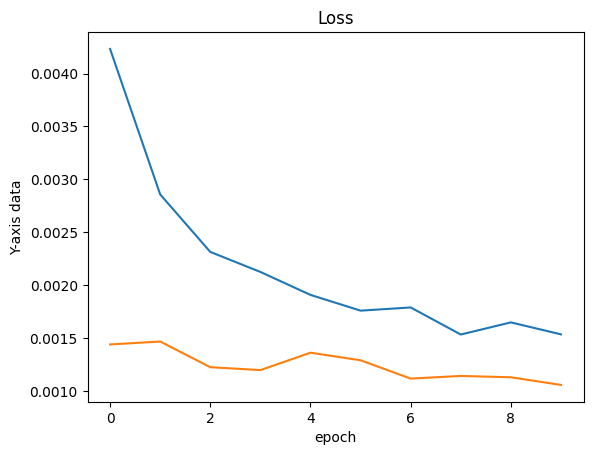

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(10))
y = eval_dict['train_loss']

# first plot with X and Y data
plt.plot(x, y)
  
x1 = np.array(range(10))
y1 = eval_dict['test_loss']
  
# second plot with x1 and y1 data
plt.plot(x1, y1)
  
plt.xlabel("epoch")
plt.ylabel("Y-axis data")
plt.title('Loss')
plt.show()

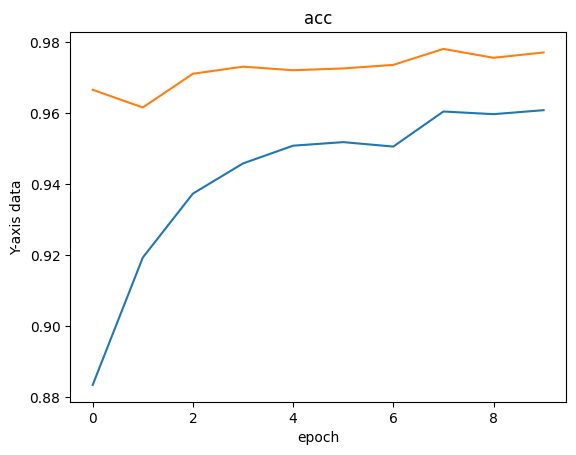

In [18]:
x = np.array(range(10))
y = eval_dict['train_acc']

# first plot with X and Y data
plt.plot(x, y)
  
x1 = np.array(range(10))
y1 = eval_dict['test_acc']
  
# second plot with x1 and y1 data
plt.plot(x1, y1)
  
plt.xlabel("epoch")
plt.ylabel("Y-axis data")
plt.title('acc')
plt.show()

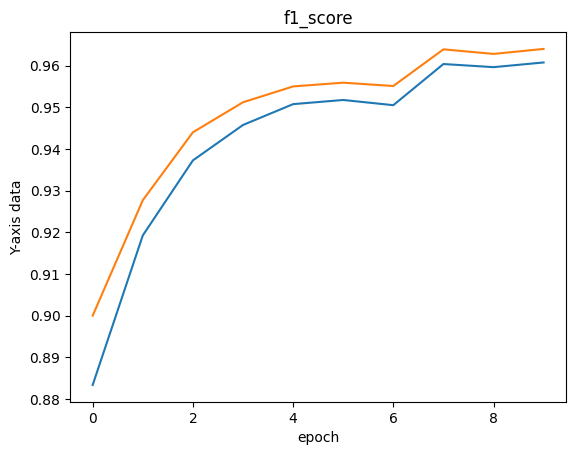

In [19]:
x = np.array(range(10))
y = eval_dict['train_f1_score']

# first plot with X and Y data
plt.plot(x, y)
  
x1 = np.array(range(10))
y1 = eval_dict['test_f1_score']
  
# second plot with x1 and y1 data
plt.plot(x1, y1)
  
plt.xlabel("epoch")
plt.ylabel("Y-axis data")
plt.title('f1_score')
plt.show()


In [20]:
def evaluate_model(model, test_loader, target_labels):
    #please define the evaluation function here
    pass

In [21]:
# evaluate_model(model, dataloders['test'], ["female", "male"])

# Predict

In [22]:
from pathlib import Path

In [23]:
def predict(model, input, class_mapping):
    checkpoint = torch.load('/content/drive/MyDrive/courses/indoai/face_recognition/model_save/point_resnet34_8020_best.pth')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    with torch.no_grad():
        prediction = model(input)
        predicted_index = prediction[0].argmax(0)
        predicted = class_mapping[predicted_index]
    return predicted
        

In [24]:
model = models.resnet34(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) 

In [25]:
class_mapping = ["female", "male"]

In [26]:
test_img = Image.open('/content/drive/MyDrive/courses/indoai/face_recognition/Datasets/images/000047.jpg')\
                .convert('RGB') 

test_img = data_transforms['test'](test_img).view(1, 3, 224,224)
class_mapping = class_mapping
predict(model, test_img, class_mapping)



# test_img, target = test_img[0][0], test_img[0][1]

# test_img = test_img.view(1, 3, 224,224)

# output = model(test_img)

# _, prediction = torch.max(output.data, 1)
# prediction = int(torch.max(output.data, 1)[1].numpy())
# print(prediction)

'female'

In [27]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
  #  transforms.Normalize(
  #      mean=[0.485, 0.456, 0.406],
  #      std=[0.229, 0.224, 0.225]
  #  )
])

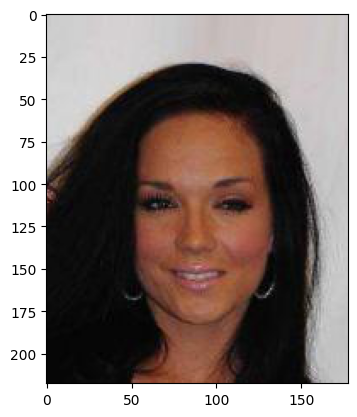

In [28]:
import matplotlib.pyplot as plt
im = Image.open('/content/drive/MyDrive/courses/indoai/face_recognition/Datasets/images/000047.jpg')
plt.imshow(im)

plt.show()

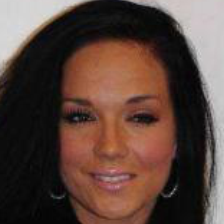

In [29]:
import torchvision
grid = torchvision.utils.make_grid(preprocess(im), nrow=10)
transforms.ToPILImage()(grid)